# II Critic's reviews - BOW approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/gabaslava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gabaslava/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Dataframe consisting of movie title, review, source of the review, and label
### Analysis will be done with 2752 samples

In [4]:
#opening the scraped critic's reviews:
df = pd.read_csv('title_review_outcome.csv')
df['review'] = df['review'].astype(str)
#eliminating 19 rows that have too few characters in the review column:
df = df[df['review'].apply(lambda x: len(x)>400)].reset_index()
df.head()

,index,title,source,review,outcome
0,0,Manchester by the Sea (2016),3brothers,"It’s hard to resist the stubborn, agonizing ch...",1
1,1,Eastern Promises (2007),3brothers,I remember Eastern Promises as a blunt physica...,0
2,2,'71 (2014),3brothers,Yann Demange’s ’71 is a rare contemporary exam...,1
3,3,A History of Violence (2005),3brothers,"At first glance, A History of Violence appears...",0
4,4,Dead Ringers (1988),3brothers,Dead Ringers is among the saddest and stranges...,1


In [5]:
len(df)

2752

In [6]:
reviews = list(df['review'].values)
outcome = list(df['outcome'].values)
info = df[['title', 'source']].values.tolist() 

## Tokenize and stem the reviews:

In [7]:
stop_words = set(stopwords.words('english'))
stop_words.update(['youve', 'theyve', 'shouldnt', 'theyll', 'werent', 'hadnt', 'hasnt', 'didnt', 'doesnt', 'wouldnt'])

stemm = PorterStemmer()


stemmed_reviews = []
for i in reviews:
    t1 = word_tokenize(i) #separating all the words into separate strings
    t2 = [w.lower() for w in t1] #converting to lower-case
    t3 = [w for w in t2 if w.isalpha()] #remove all elements that are not alpahbetical
    t4 = [w for w in t3 if w not in stop_words] #eliminating stop-words
    t0 = [stemm.stem(w) for w in t4]
    stemmed_reviews.append(t0)
    
#getting rid of the the texts that have 100 words and less
X=[]
Y=[]
G=[]
# eliminates reviews that don't meet the threshold
for i,e,f in zip(stemmed_reviews,outcome,info):
    if len(i)>100:
        X.append(i)
        Y.append(e)
        G.append(f)

In [8]:
Counter(Y)

Counter({1: 1376, 0: 1362})

### Cleaned sample now consists of 2738 reviews: 1376 categorized as Positive Sentiment and 1362 as Negative Sentiment

### Longest review has of 5600 stemmed words , shortest - 102 words.
### On average review has 471 words with standard deviation of 225.
### Total word count(non unique) for all reviews combined is alsmot 1.3M.

In [9]:
max_len = max([len(i) for i in X]) #longest review(number of words)
min_len = min([len(i) for i in X]) #shortest review(number of words)
mean_x = np.mean([len(i) for i in X]) #average review
std_x = np.std([len(i) for i in X]) #stadard deviation
total_x = sum([len(i) for i in X]) #total word count/non-unique

max_len, min_len, round(mean_x,1), round(std_x,1), total_x 

(5600, 102, 471.8, 225.3, 1291779)

# Applying Bag of Words model using sklearn's CountVectorizer to convert reviews into matrixes of unique word counts and preparing to fit the data on a Logistic Regression model

### Each sample text will be represented as a sparse matrix shaped (2738, 35330). The rows being length of sample size(there are 2738 reviews) and columns being unique word count. Each word found by the analyzer during the fit is assigned a unique integer index corresponding to a column in the resulting matrix.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

#the data fed to CountVectorizer has to be represented as joined text
#one_hot representation of outcome will be applied for training a neural network 
X_texts = [' '.join(i) for i in X] 
Y_onehot = np.eye(2)[np.array(Y)]


vectorizer = CountVectorizer()
vectorizer.fit(X_texts)
X_asvectors = vectorizer.transform(X_texts)

# Issue with this approach is that long texts have much more impact than short texts because they have more words so the matrixes have more weight. 
# To eliminate this issue, each word will be divided by total word count in the specific sample.
tfidf = TfidfTransformer()
X_tfidf_vectors = tfidf.fit_transform(X_asvectors)

print(X_tfidf_vectors.shape)

(2738, 35330)


### Splitting the data into training and testing frames

In [11]:
#data for logistic regression and SVM model:
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf_vectors, np.array(Y), test_size=0.2, random_state=98)
#data for neural network model:
X_train_neur, X_test_neur, Y_train_neur, Y_test_neur = train_test_split(X_tfidf_vectors, Y_onehot, test_size=0.2, random_state=98)
#additional data for later prediction evaluation
G_train, G_test = train_test_split(G, test_size=0.2, random_state=98)
print('Training data shape: %s, training labels shape: %s \nValidation data shape: %s, validation labels shape: %s' %(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Training data shape: (2190, 35330), training labels shape: (2190,) 
Validation data shape: (548, 35330), validation labels shape: (548,)


### Based solely on the words being used in the reviews, Logistic regression algorithm can distinguish positive sentiment from negative sentiment with 79% accuracy

In [12]:
from sklearn.linear_model import LogisticRegression

log_classifier = LogisticRegression()
log_classifier.fit(X_train, Y_train)
acc = log_classifier.score(X_test, Y_test) *100
print('Accuracy score for test sample is %.f%% ' % round(acc,1))

Accuracy score for test sample is 79% 


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Using Support Vector Machines algorithm the classification is even better - 86%

In [13]:
from sklearn.svm import SVC

svc_classifier = SVC(kernel='linear', gamma='auto')  
svc_classifier.fit(X_train, Y_train)
acc_svc = svc_classifier.score(X_test, Y_test) *100
print('Accuracy score for test sample is %.f%% ' % round(acc_svc,1))

Accuracy score for test sample is 86% 


### Based on a Neural Network built with keras, categorization can be achieved with 89% accuracy

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [31]:
input_dim = X_train_neur.shape[1]  # Number of features (i.e. unique words)

neuralmodel = Sequential()
neuralmodel.add(Dense(50, input_dim=input_dim, activation='relu'))
neuralmodel.add(Dropout(0.55))
neuralmodel.add(Dense(2, activation='softmax'))

neuralmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
neuralmodel.summary()

history = neuralmodel.fit(X_train_neur, Y_train_neur, epochs=30, batch_size=40, validation_data=(X_test_neur, Y_test_neur))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 50)                1766550   
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 102       
Total params: 1,766,652
Trainable params: 1,766,652
Non-trainable params: 0
_________________________________________________________________
Train on 2190 samples, validate on 548 samples
Epoch 1/30
2190/2190 [==============================] - 9s 4ms/step - loss: 0.6810 - acc: 0.5822 - val_loss: 0.6636 - val_acc: 0.7609
Epoch 2/30
2190/2190 [==============================] - 6s 3ms/step - loss: 0.5724 - acc: 0.8703 - val_loss: 0.5934 - val_acc: 0.7883
Epoch 3/30
2190/2190 [==============================] - 6s 3ms/step - loss: 0.399

### Training accuracy and loss versus validation accuracy and loss during the 30 learning epochs plotted

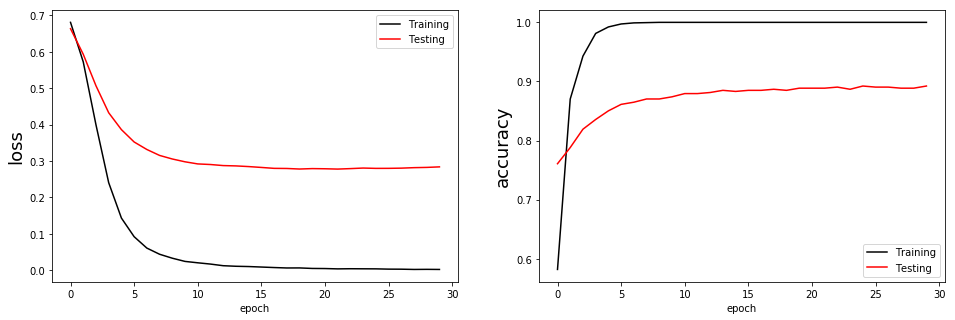

In [32]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.epoch, history.history['loss'], c='k', label='Training')
ax1.plot(history.epoch, history.history['val_loss'], c='r', label='Testing')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', size=18)
ax1.legend()

ax2.plot(history.epoch, history.history['acc'], c='k', label='Training')
ax2.plot(history.epoch, history.history['val_acc'], c='r', label='Testing')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy', size=18)
ax2.legend();

### Positive and negative sentiments are predicted with almost the same accuracy:

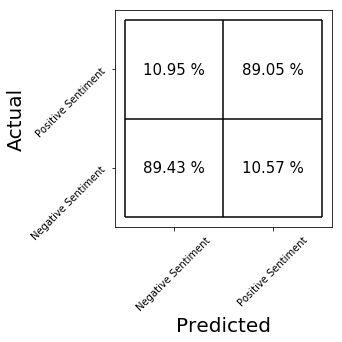

In [33]:
import itertools
from sklearn.metrics import confusion_matrix

predictions = neuralmodel.predict(X_test_neur)
matri=confusion_matrix(Y_test_neur.argmax(axis=1), predictions.argmax(axis=1))
normalized_matrix=matri/matri.sum(axis=1)[:, np.newaxis] *100

height, width = normalized_matrix.shape

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
for x in range(width):
    for y in range(height):
        ax.annotate(str(normalized_matrix[x][y].round(2))+' %', xy=(y, x), ha='center', va='center', size=15)
offset = 0.5
plt.xticks([0,1], ['Negative Sentiment','Positive Sentiment'], rotation=45)
plt.yticks([0,1], ['Negative Sentiment','Positive Sentiment'], rotation=45)
plt.xlabel('Predicted', size=20)
plt.ylabel('Actual', size=20)
ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset);

### Model is making correct predictions with more confidence:

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


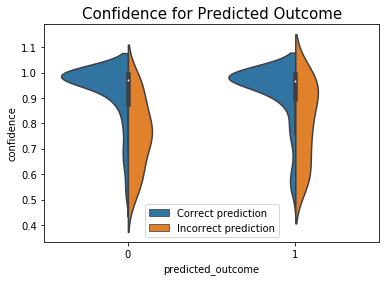

In [34]:
import seaborn as sns
#function extracting predicted outcome and the confidence from softmax
def pred_confidence(y_predicted, y_test):
    real = np.argmax(y_test, axis=1)
    pred = np.argmax(y_predicted, axis=1)
    prob = np.max(y_predicted, axis=1)
    accuracy=[]
    for i in range(len(real)):
        if real[i]==pred[i]:
            accuracy.append('Correct prediction')
        else:
            accuracy.append('Incorrect prediction')
    return pd.DataFrame({'predicted_outcome': pred, 'confidence': prob, 'accurate':accuracy})

confid = pred_confidence(predictions, Y_test_neur)

p=sns.violinplot('predicted_outcome', 'confidence', data=confid, hue='accurate', split=True)
p.legend(loc='lower center')
plt.title('Confidence for Predicted Outcome', size=15);

In [35]:
test_title_source = pd.DataFrame(G_test, columns=['title', 'source'])
test_info = pd.concat([confid, test_title_source], axis=1)
test_info = test_info[['title', 'source', 'accurate', 'predicted_outcome', 'confidence']]
test_info['accurate'] = test_info['accurate'].map({'Correct prediction': 1, 'Incorrect prediction': 0})
test_info.tail()

,title,source,accurate,predicted_outcome,confidence
543,Thank You for Smoking (2005),reel,1,1,0.992512
544,Magnolia (1999),reel,1,1,0.993000
545,The Lobster (2015),nytimes,1,1,0.993033
546,Spindesys (1996),ebert,1,0,0.946649
547,Reign Over Me (2007),nytimes,1,1,0.592723


### Checking how accurate the prediction is for different review source:

In [36]:
src=[]
count=[]
acc=[]
for i in ['ebert', 'nytimes', 'reel', 'cinefile', 'alibi', 'metropolitan', 'bright_lights', '3brothers']:
    critic = test_info[test_info['source'] == i]
    print('%s critic testing sample size is %d, accuracy for testing data is %.1f%%' % (i,len(critic),round(np.mean(critic['accurate'].values)*100,1)))
    if len(critic)>70:
        src.append(i)
        count.append(len(critic))
        acc.append(sum(critic['accurate']))

ebert critic testing sample size is 174, accuracy for testing data is 87.4%
nytimes critic testing sample size is 123, accuracy for testing data is 93.5%
reel critic testing sample size is 82, accuracy for testing data is 93.9%
cinefile critic testing sample size is 104, accuracy for testing data is 82.7%
alibi critic testing sample size is 42, accuracy for testing data is 90.5%
metropolitan critic testing sample size is 9, accuracy for testing data is 100.0%
bright_lights critic testing sample size is 11, accuracy for testing data is 81.8%
3brothers critic testing sample size is 3, accuracy for testing data is 100.0%


### Appears that New York Times and ReelView critic reviews are being categorized more accurately 

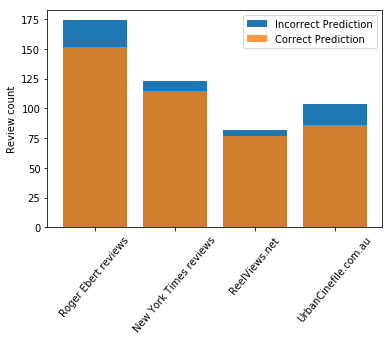

In [37]:
p1 = plt.bar(src, count)
p2 = plt.bar(src, acc, alpha=0.8)
plt.ylabel('Review count')
plt.xticks(src, ('Roger Ebert reviews', 'New York Times reviews', 'ReelViews.net', 'UrbanCinefile.com.au'), rotation=50)
plt.legend((p1[0], p2[0]), ('Incorrect Prediction', 'Correct Prediction'));